In [298]:
from collections import Counter
import csv
import descartes
import fiona
import gensim
from geopandas import GeoDataFrame
import geopy
from IPython.display import Image
from IPython.display import display
import lda
import logging
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from mpl_toolkits import basemap
import mpl_toolkits
import numpy as np
import pandas as pd
import pickle
from pprint import pprint
import pyper as pr
import shapely
import sys

%matplotlib inline


In [221]:
def csv2ListOfLists(filename,delimiter='\t'):
    data = [];
    with open(filename,'rb')as dataFile:
        dataReader = csv.reader(dataFile, delimiter=delimiter, quotechar='|')
        counter = 0
        for i,row in enumerate(dataReader):
            temporaryRow = []
            for j,entry in enumerate(row):
                temporaryRow.append(entry) 
            data.append(temporaryRow)
        dataFile.close()
    return data
        
            


<h2>Step 1 -  Preprocessing the database and converting it to a term-frequency matrix </h2>

<p>We've got a database of species observations downloaded from GBIF.org and it's in CSV format with a bunch of extraneous information. We eventually need to convert this into a term-frequency matrix which indicates the presence or absence of a recorded observation of a given species at a certain location. We'd like to first clean out some stuff that we don't need. We'll need to perform the following steps: </p>

<ul>
<li>Load the database into a pandas dataframe</li>
<li>Drop any columns which we don't need for this project</li>
<li>Filter out any observations which are not recorded at the 'species' taxonomy level</li>
<li>Filter out any observations which cannot be georeferenced to a grid cell of 1 square kilometer or smaller, i.e. the uncertainty radius is too big</li>
</ul>



In [3]:
# WARNING! THIS STEP TAKES A LONG TIME ESPECIALLY IF YOU HAVE A SLOW HD!

# We will print off a lot of info to a log file so we can make sure everything is going smoothly and debug if we need.
logFile = 'log.txt'
logging.basicConfig(filename=logFile,level=logging.INFO)

# The following line takes a CSV filename in the current directory and reads it as a list of lists
# Normally we would want to do a direct import with read_csv and pandas, but there is an error that fires off when we try that.
logging.info("Loading list of lists from CSV file")
occurrenceArray = csv2ListOfLists('occurrence.txt')


In [4]:
# The first list in the list of lists 'occurrenceArray' contains the column name information.
# We'll use that info to name the columns in the pandas dataframe.
logging.info("Converting list of lists to pandas dataframe")
rawOccurrenceDF = pd.DataFrame(occurrenceArray[1:],columns = occurrenceArray[0])


# Let's also keep track of how many records were initially in this database.
rawRecordCount = rawOccurrenceDF.shape[0]

# We need to indicate which columns from this database we'd like to keep and discard the rest.
columnsToKeep = ['id','verbatimCoordinates','decimalLatitude','decimalLongitude','scientificName','taxonRank','coordinateUncertaintyInMeters']

# And we will do an in-place replacement with a reduced pandas dataframe
logging.info("\n Dropping unwanted database fields... \n")
occurrenceDF = rawOccurrenceDF[columnsToKeep]

# Our next step is to eliminate any observation records which do not have a taxonomic rank of "Species".
logging.info("\n Filtering records based on taxon rank... \n")
occurrenceDF = occurrenceDF.query('(taxonRank == "Species")')

# We would also like to eliminate any records in which the uncertainty estimate of location is greater than 1 kilometer.
logging.info("\n Culling records with uncertainty >1000 m. in observation location... \n")
occurrenceDF= occurrenceDF[occurrenceDF.coordinateUncertaintyInMeters.apply(float) <= 1001.0]

processedRecordCount = occurrenceDF.shape[0]

# It would be nice to see some statistics regarding how many records we dropped.
logging.info("\nOut of {:d} records downloaded, {:d} were dropped and {:d} remain in the database.".format(rawRecordCount,processedRecordCount,rawRecordCount-processedRecordCount))


<h2>Step 2 -  Converting the database to a term-frequency matrix </h2>

<p>Now that the data is cleaned up, we can apply a transformation which will give us a new dataframe in which the row index denotes physical location and the column denotes species presence/absence. Thankfully, pandas has functionality which makes this very easy. </p>


In [7]:
# First, we need to get a list of spatially unique physical locations and also a list of unique species
uniqueLocations = pd.unique(occurrenceDF.verbatimCoordinates.ravel())
uniqueSpecies = pd.unique(occurrenceDF.scientificName.ravel())

# We'll create a new dataframe with the two lists above as the row and column indices
logging.info("\n Creating tf dataframe... \n")
termFrequencyDF = pd.DataFrame(index = uniqueLocations, columns = uniqueSpecies)
termFrequencyDF = termFrequencyDF.fillna(0) # Normally, empty values are initalized to NaN but we want the empties to be set to zero.



# Here, we loop over the occurrence dataframe and populate the term frequency dataframe with the information from the former.
logging.info("\n Filling tf frame with species info \n")
for tup in occurrenceDF[['verbatimCoordinates','scientificName']].itertuples(index=False):
    termFrequencyDF[tup[1]][tup[0]] += 1
    
# The entries in the tf frame are counts, but we really only want presence or absence so we are going to create a new frame with 1s and 0s.
presenceDF = termFrequencyDF.clip(upper=1)


<h2>Step 3 - Finding an optimal number of communities via model selection</h2>
<p>Our next step is to use a package written in R by Matthew Taddy at U.Chicago to identify a best setting for the number of communities in our data set, i.e. to find the proper number of topics in latent Dirichlet allocation. I'd recommend giving his arxiv preprint a read: http://arxiv.org/abs/1109.4518 . We are going to use a python package called Pyper to call out to an R process and run the R code before extracting the information that we want regarding the best number of communities and some diagnostic info regarding this optimization process. </p>






In [134]:
# WARNING! This cell also takes a long time to run because of the model selection scheme in R.
# We want to examine a wide range of possible community numbers, i.e. K, but this is computationally expensive.

# First, let's initalize an instance of R which is controlled by the Python kernel via pyper.
r = pr.R()

# Pyper can send data back and forth via frames or matrices but we're going to use a file drop because it will be much faster.
dropFilename = 'presenceMatrixForR.csv'
presenceDF.to_csv(dropFilename,delimiter = ',',header=False,index=False)

# maptpx is the name of the R package we'll use.
r('library(maptpx)')
r('presence<-read.table(\'/home/chris/Dropbox/Public/LDA_project/project_repository/creative/' + dropFilename + '\',sep=\',\')')
r('matrix <- data.matrix(presence)')

# In this scenario, we'll search from possible community numbers from 2 to 40 but this can be adjusted.
logging.info("\n Performing model selection... \n")
outputString = r('summary(simselect <- topics(matrix, K=seq(2,40)), nwrd=0)')

# This extracts the optimal number of communities K per the model selection scheme.
K = r.get('simselect$K')
logging.info("\n The optimal number of communities was identified to be + " + str(K) + ".\n") 

print outputString


try({summary(simselect <- topics(matrix, K=seq(2,40)), nwrd=0)})

Estimating on a 12723 document collection.
Fit and Bayes Factor Estimation for K = 2 ... 40
log posterior increase: 3967.5, done.
log BF( 2 ) = 141187.32
log posterior increase: 51299.8, done.
log BF( 3 ) = 253040.54
log posterior increase: 22698.6, done.
log BF( 4 ) = 312046.32
log posterior increase: 19937.4, 1370.3, done.
log BF( 5 ) = 392405.79
log posterior increase: 9711.2, 1022.2, done.
log BF( 6 ) = 427097.44
log posterior increase: 9287.5, 807.9, done.
log BF( 7 ) = 457625.74
log posterior increase: 8611.8, 470.9, done.
log BF( 8 ) = 481101.96
log posterior increase: 7802.5, 1111.1, done.
log BF( 9 ) = 505494
log posterior increase: 6684.3, 302.2, done.
log BF( 10 ) = 526960.74
log posterior increase: 6440.4, 411.8, done.
log BF( 11 ) = 538404.01
log posterior increase: 5867.8, 441.2, 321.8, done.
log BF( 12 ) = 550324.99
log posterior increase: 6000.6, 537.8, 223.9, done.
log BF( 13 ) = 566334.38
log posterior 

<h2>Step 4 - Performing hyperparameter optimization using Gensim</h2>
<p> While many previous works in applied topic modeling were unconcerned about settings of the priors alpha and eta, Hanna Wallach made a strong case for investigating how they are chosen in a 2009 paper. Check it out here if you're interested: https://people.cs.umass.edu/~wallach/publications/wallach09rethinking.pdf. We're going to use a topic modeling package which can learn the best LDA hyperparameter / prior settings directly from the data with Gensim per the recommendations from that paper.  </p>



In [135]:
# Gensim has its own corpus format that we need to convert to from a numpy matrix / pandas dataframe
presenceGS = gensim.matutils.Dense2Corpus(np.copy(presenceDF.values), documents_columns=False)
model = gensim.models.ldamodel.LdaModel(corpus=presenceGS, num_topics=K, distributed=False, alpha='auto', eta='auto', iterations = 20, passes = 2, minimum_probability = 0.001)

# Let's also extract the parameter matrices that were estimated.
# This pulls out the set of location-community distributions, commonly referred to in the literature as theta.
theta =  gensim.matutils.corpus2dense(model[presenceGS],model.num_topics)

# And here's the unnormalized community-species distributions.
phi = model.expElogbeta

# As the final step, we extract the inferred hyperparameters so we can use them in other LDA runs.
alpha = model.alpha
eta = model.eta

<h2>Step 5 - Analyzing communities-species and location-community relationships</h2>
<p>In the previous code block we ran an inference routine (variational expectation maximization as an implementation of the methods outlined by Hoffman et al. 2010 at http://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf) to identify optimal settings of the hyperparameters alpha and eta. We also identified lots of interesting structure so let's take a look at the spatial distributions of the communities we identified as well as the indicator species which each community contains. </p>

In [188]:
# The first thing we are going to do is rewrite the parameters that we got into pandas dataframes so we can see which species are most important for each community.
speciesCommunityDF = pd.DataFrame(data = phi, index = [str(i) for i in range(1,K+1)],columns = presenceDF.columns.values)

# We will do the same for the community-location parameters.
communityLocationDF = pd.DataFrame(data = theta.transpose(), index = presenceDF.index.values, columns = ['community'+str(i) for i in range(1,K+1)])

# To make spatial plots of community prominence, we need to join tables.
# The next line is tricky - we're going to merge with occurrenceDF but we don't need all 3 million records. We only want the unique plot ID values and the corresponding spatial coordinates.
communityLocationDF = pd.merge(communityLocationDF,occurrenceDF.drop_duplicates(subset=['verbatimCoordinates']),right_on='verbatimCoordinates',how='left',left_index=True)

# We should also get rid of unnecessary columns which got merged from the occurrence dataframe.
communityLocationDF = communityLocationDF.drop(['id','coordinateUncertaintyInMeters','scientificName','taxonRank'],axis=1)
communityLocationDF = communityLocationDF.set_index('verbatimCoordinates')

# While we're at it, let's make a new directory for our dataframes and save them in case we want to come back later and skip all the busywork.
! mkdir dataframes
dfFilenames = ['speciesCommunityDF','communityLocationDF','termFrequencyDF','occurrenceDF']
for i,frame in enumerate([speciesCommunityDF,communityLocationDF,termFrequencyDF,occurrenceDF]):
    frame.to_csv('dataframes/'+dfFilenames[i]+'.csv')

<h2>A brief interlude</h2>
<p> It's time to save our significant work so far, namely the pandas dataframes which we've been making up until now. </p>

In [313]:
# While we're at it, let's make a new directory for our dataframes and save them in case we want to come back later and skip all the busywork.
! mkdir dataframes
dfFilenames = ['speciesCommunityDF','communityLocationDF','termFrequencyDF','occurrenceDF']
for i,frame in enumerate([speciesCommunityDF,communityLocationDF,termFrequencyDF,occurrenceDF]):
    frame.to_csv('dataframes/'+dfFilenames[i]+'.csv')

mkdir: cannot create directory ‘dataframes’: File exists


<h2>Step 5a - Projecting geospatial data and plotting it with matplotlib </h2>

<p>Things are about to get crazy. The projection and plotting will follow along the lines of the workflows described here: https://peak5390.wordpress.com/2012/12/08/matplotlib-basemap-tutorial-plotting-points-on-a-simple-map/ and also from the mpl homepage http://matplotlib.org/basemap/users/examples.html. </p>

[<IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>]

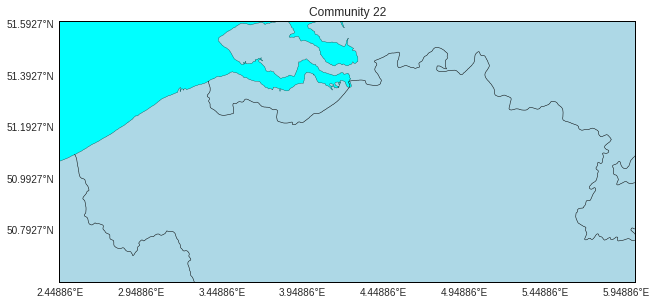

In [299]:

fig = plt.figure(figsize=(10,5))
ax=fig.add_axes([0.1,0.1,0.8,0.8])

# We are going to use the Basemap class from the matplotlib toolkits library.
# The extent of our map is going to be over the latitudes/longitudes in which there is data.

lowerLeftCornerLongitude  = min([float(i) for i in communityLocationDF['decimalLongitude'].values])-.1
lowerLeftCornerLatitude   = min([float(i) for i in communityLocationDF['decimalLatitude'].values])-.1
upperRightCornerLongitude = max([float(i) for i in communityLocationDF['decimalLongitude'].values])+.1
upperRightCornerLatitude  = max([float(i) for i in communityLocationDF['decimalLatitude'].values])+.1

# The projection we want to use is the Mercator projection.
# Rendering all of this is highly dependent on the resolution.
# The resolution can be changed to 'l' if this generates too slowly.
map = basemap.Basemap(projection='merc',
                      llcrnrlon=lowerLeftCornerLongitude,
                      llcrnrlat=lowerLeftCornerLatitude,
                      urcrnrlon=upperRightCornerLongitude,
                      urcrnrlat=upperRightCornerLatitude,
                      resolution='f')
map.drawcoastlines(linewidth=0.25)
map.drawcountries(linewidth=0.5)
map.fillcontinents(color='lightblue',lake_color='aqua',zorder=0)
map.drawmapboundary(fill_color='aqua')
map.drawparallels(np.arange(lowerLeftCornerLatitude,upperRightCornerLatitude,.2),labels=[1,0,0,0], linewidth=0.0)
map.drawmeridians(np.arange(lowerLeftCornerLongitude,upperRightCornerLongitude,.5),labels=[0,0,0,1], linewidth=0.0)


# To visualize the prominence of communities across space, we're going to make our own sort-of colormap.
# It won't be a real colormap; we're just messing with the alpha values. Higher prominence means higher alpha.
rgbaColors = np.zeros((len(alphas),4))
rgbaColors[:,1] = 0.5

# These are the latitude-longitude coordinates.
x = [float(i) for i in communityLocationDF['decimalLongitude'].values]
y = [float(i) for i in communityLocationDF['decimalLatitude'].values]

# This array will hold a list of ipython image objects so we can show the plots in Ipython quickly later.
ipythonImages = []

# We'll also create a directory to put the saved image files in.
! mkdir basemap_community_plots

for i in range(1,K+1):
    alphas = communityLocationDF['community'+str(i)].values
    
    rgbaColors[:,3] = alphas/alphas.max()
    
    sc = map.scatter(x,y,latlon=True,s=4,c=rgbaColors,edgecolor='')
    plt.title('Community '+str(i))
    plt.savefig('basemap_community_plots/community'+str(i)+'.png',dpi=1000)
    ipythonImages.append(Image(filename='community'+str(i)+'.png'))
    sc.remove()
del fig


In [256]:
map.scatter?

In [288]:
min([float(i) for i in communityLocationDF['decimalLongitude'].values])

2.54886

In [293]:
map.scatter?

In [300]:
display?

In [302]:
display(tuple(ipythonImages))

(<IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>,
 <IPython.core.display.Image object>)

In [311]:
! mkdir basemap_community_plots

mkdir: cannot create directory ‘basemap_community_plots’: File exists


In [312]:
locals()

KeyboardInterrupt: 